Loading data

In [1]:
import os
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from esm.models.esmc import ESMC
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from model.MLP_enzymes import MLP_enzymes
from model.random_forest_enzymes import random_forest_enzymes
from utils import initialize_esm_client
from utils.esmc_embedding import esmc_embedding
from utils.evaluation_metrics import evaluation_metrics
from utils.get_features import get_features
from utils.load_fasta import load_fasta
from utils.concat_sequences import concat_sequences
from utils.train_mlp import train_mlp

ready_data_path = 'data/embeddings.csv'

if not os.path.exists(ready_data_path):
    
    print(f"File {ready_data_path} not found, loading fasta")
    # Path to FASTA files
    enzyme_path = 'data/enzyme/enzyme.fasta'
    not_enzyme_path = 'data/not_enzyme/not_enzyme.fasta'

    # Load FASTA files to Seq
    enzyme, not_enzyme = load_fasta(enzyme_path, not_enzyme_path)

    # Create features of every sequence
    enzyme_features = get_features(enzyme)
    not_enzyme_features = get_features(not_enzyme)

    client = ESMC.from_pretrained("esmc_300m").to("cpu")

    # Create embeddings of every sequence
    enzyme_embedding = esmc_embedding(enzyme, client)
    not_enzyme_embedding = esmc_embedding(not_enzyme, client)

    # Concat enzymes and not enzymes
    proteins = concat_sequences(enzyme_embedding, not_enzyme_embedding, ready_data_path)
else:
    print(f"Found {ready_data_path}, loading it")
    proteins = pd.read_csv(ready_data_path)

# Split train and test data
x_train, x_test, y_train, y_test = train_test_split(proteins.iloc[:, 0:-1], proteins['labels'], test_size=0.2, random_state=42, stratify=proteins['labels'])

c:\Users\mateu\OneDrive\Pulpit\studia\ib\python\enzyme-classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found data/embeddings.csv, loading it


Random Forest

In [2]:
# Create random forest model
model_random_forest = random_forest_enzymes(x_train, y_train)

# Predictions of random forest model
y_predict_rf = model_random_forest.predict(x_test)

# Calculate evaluation metrics of rf model
accuracy_rf, f1_rf, conf_matrix_rf = evaluation_metrics(y_test, y_predict_rf)

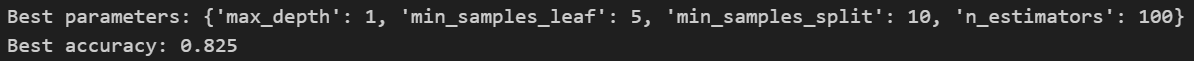

MLP

960
Epoch 20/600, Loss 0.6926
Epoch 40/600, Loss 0.6897
Epoch 60/600, Loss 0.6836
Epoch 80/600, Loss 0.6738
Epoch 100/600, Loss 0.6575
Epoch 120/600, Loss 0.6290
Epoch 140/600, Loss 0.5835
Epoch 160/600, Loss 0.5250
Epoch 180/600, Loss 0.4643
Epoch 200/600, Loss 0.4070
Epoch 220/600, Loss 0.3652
Epoch 240/600, Loss 0.3350
Epoch 260/600, Loss 0.3127
Epoch 280/600, Loss 0.2949
Epoch 300/600, Loss 0.2798
Epoch 320/600, Loss 0.2666
Epoch 340/600, Loss 0.2550
Epoch 360/600, Loss 0.2449
Epoch 380/600, Loss 0.2361
Epoch 400/600, Loss 0.2284
Epoch 420/600, Loss 0.2215
Epoch 440/600, Loss 0.2155
Epoch 460/600, Loss 0.2100
Epoch 480/600, Loss 0.2050
Epoch 500/600, Loss 0.2004
Epoch 520/600, Loss 0.1960
Epoch 540/600, Loss 0.1920
Epoch 560/600, Loss 0.1882
Epoch 580/600, Loss 0.1846
Epoch 600/600, Loss 0.1813


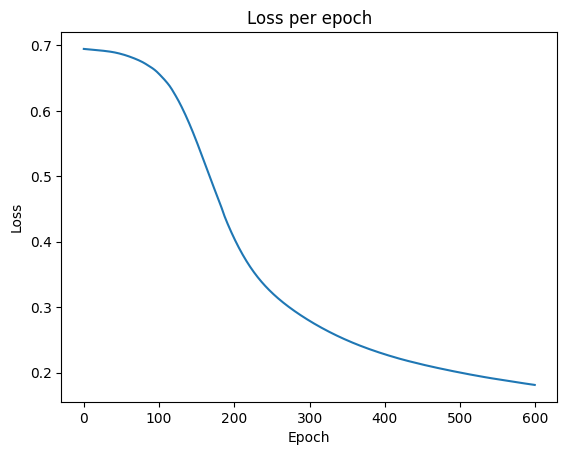

In [3]:
# Transform data sets into tensors
x_test_tensor = torch.tensor(x_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)
x_train_tensor = torch.tensor(x_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)

# Create MLP model
input_len = len(x_test_tensor[1])
print(input_len)
model_MLP = MLP_enzymes(input_len)

# Train model
train_mlp(model_MLP, x_train_tensor, y_train_tensor)

# Set model to evaluate
model_MLP.eval()

# Get predicted value
with torch.no_grad():
    y_predict_MLP = model_MLP(x_test_tensor)

    _, predicted_classes_MLP = torch.max(y_predict_MLP, 1)

# Transform predicted values to numpy
predicted_classes_MLP_npy = predicted_classes_MLP.cpu().numpy()

# Get evaluation metrics of MLP model
accuracy_MLP, f1_MLP, conf_matrix_MLP = evaluation_metrics(y_test, predicted_classes_MLP_npy)

Results

---------- RANDOM FOREST ----------
Accuracy 0.7615
F1 Score 0.7648
[[1205  407]
 [ 362 1250]]
---------- MLP ----------
Accuracy 0.9215
F1 Score 0.9219
[[1478  134]
 [ 119 1493]]


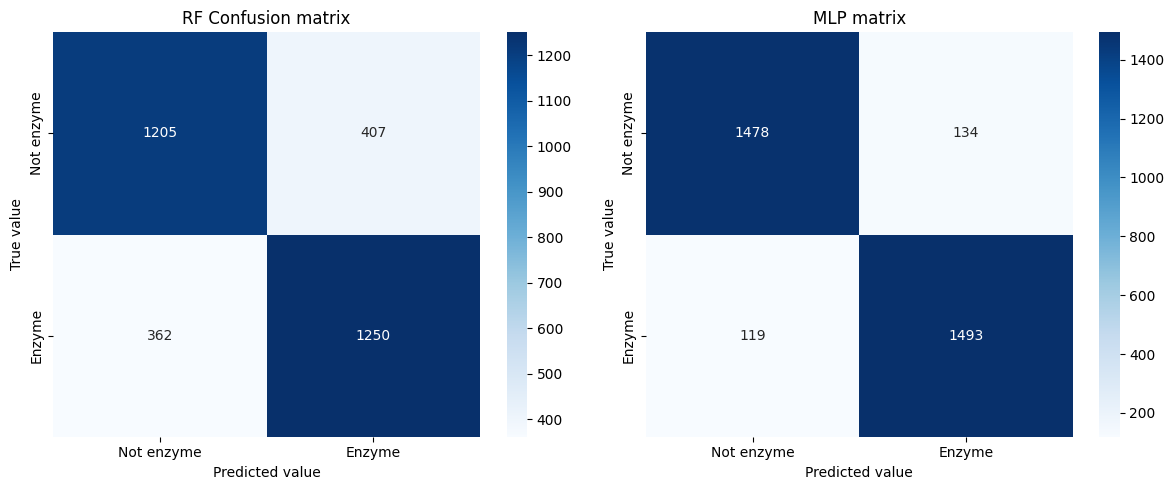

In [4]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Print evaluation metrics of RF
print("---------- RANDOM FOREST ----------")
print(f"Accuracy {accuracy_rf:.4f}")
print(f"F1 Score {f1_rf:.4f}")
print(f"{conf_matrix_rf}")

# Create RF heatmap of conf_matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not enzyme', 'Enzyme'], yticklabels=['Not enzyme', 'Enzyme'],
            ax=axes[0])
axes[0].set_title('RF Confusion matrix')
axes[0].set_ylabel('True value')
axes[0].set_xlabel('Predicted value')

# Print evaluation metrics of MLP
print("---------- MLP ----------")
print(f"Accuracy {accuracy_MLP:.4f}")
print(f"F1 Score {f1_MLP:.4f}")
print(f"{conf_matrix_MLP}")

# Create MLP heatmap of conf_matrix
sns.heatmap(conf_matrix_MLP, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not enzyme', 'Enzyme'], yticklabels=['Not enzyme', 'Enzyme'],
            ax=axes[1])
axes[1].set_title('MLP matrix')
axes[1].set_ylabel('True value')
axes[1].set_xlabel('Predicted value')

# Print heatmaps
plt.tight_layout()
plt.show()